In [201]:
from bs4 import BeautifulSoup
import numpy as np, seaborn as sns, matplotlib.pyplot as plt, warnings, time, requests, pandas as pd
warnings.filterwarnings("ignore")
from google.colab import output

In [188]:
ids = pd.read_csv('https://raw.githubusercontent.com/fmathews11/College_Basketball_Functions/main/ids.csv')
convert_dict = {'MIN':int,
               'OREB':int,
               'DREB':int,
               'REB':int,
               'AST':int,
               'STL':int,
               'BLK':int,
               'TO':int,
               'PF':int,
               'PTS':int,
               'FGM':int,
               'FGA':int,
               '3PM':int,
               '3PA':int,
               'FTM':int,
               'FTA':int}
col_order = ['Player',
                 'PTS',
                 'MIN',
                 'FGM',
                 'FGA',
                 '3PM',
                 '3PA',
                 'FTM',
                 'FTA',
                 'OREB',
                 'DREB',
                 'REB',
                 'AST',
                 'STL',
                 'BLK',
                 'TO',
                 'PF',
                 'Position']

def calculate_possessions(fga,orebs,tos,fta):
    value = (fga-orebs) + tos + (0.475*fta)
    return value

def clean_up_boxscore(df):
    df = df.iloc[:len(df)-2,]
    df['Position'] = [i[-1] for i in df.Starters]
    df = df.infer_objects()
    df.Starters = [i[:int((len(i)-1)/2)] for i in df.Starters]
    df['FGM'] = [i[0] for i in df.FG.str.split('-')]
    df['FGA'] = [i[1] for i in df.FG.str.split('-')]
    df['3PM'] = [i[0] for i in df['3PT'].str.split('-')]
    df['3PA'] = [i[1] for i in df['3PT'].str.split('-')]
    df['FTM'] = [i[0] for i in df.FT.str.split('-')]
    df['FTA'] = [i[1] for i in df.FT.str.split('-')]
    if type(df.MIN[0]) == str:
      df.MIN = 0
    df = df.astype(convert_dict)
    df = df.append(df.sum(numeric_only = True),ignore_index = True)
    last_row = len(df) - 1
    df = df.rename(columns = {"Starters":"Player"})
    df = df[col_order]
    df.iloc[last_row,0] = 'Team'
    df.iloc[last_row,17] = ""
    return df.astype(convert_dict)

def get_boxscores(game_id,disp = False):

  #Create the URL and pull in the HTML
  url = 'https://www.espn.com/mens-college-basketball/boxscore/_/gameId/'+str(game_id)
  r = requests.get(url)
  soup = BeautifulSoup(r.content,'lxml')

  #Isolate the home team, away team, and game date.  Away team is always first
  away_team = str(soup.find('title')).split('-')[0].replace("<title>","").strip().split(' vs. ')[0]
  home_team = str(soup.find('title')).split('-')[0].replace("<title>","").strip().split(' vs. ')[1]
  game_date = str(soup.find("title")).split("-")[2].strip()

  #Infer tables with Pandas
  dfs = pd.read_html(url)
  #Away team is always index value 1, home team is 2
  away_team_df = dfs[1]
  home_team_df = dfs[2]
  # Convert columns from tuples to strings
  if type(away_team_df.columns[0]) is tuple:
    away_team_df.columns = [i[0] for i in away_team_df.columns.tolist()]
  if type(home_team_df.columns[0]) is tuple:
    home_team_df.columns = [i[0] for i in home_team_df.columns.tolist()]

  #Clean the dataframes
  away_team_df = clean_up_boxscore(away_team_df)
  home_team_df = clean_up_boxscore(home_team_df)
  #Create outer index
  away_team_df = pd.concat({away_team:away_team_df})
  home_team_df = pd.concat({home_team:home_team_df})

  if disp:
    display(away_team_df,home_team_df)
  else:
    return away_team_df,home_team_df

def get_agg_boxscore(game_id,disp = True):
    df_away,df_home = get_boxscores(game_id)
    away_team = df_away.index[0][0]
    home_team = df_home.index[0][0]
    last_row = len(df_away)
    df_away = df_away.iloc[last_row-1:]
    df_away = df_away[["PTS",
          "FGM",
          "FGA",
          "3PM",
          "3PA",
          "FTM",
          "FTA",
          "OREB",
          "DREB",
          "TO"]].reset_index().drop('level_1',1).rename(columns = {'level_0':'Team'}).set_index("Team")

    last_row = len(df_home)
    df_home = df_home.iloc[last_row-1:]
    df_home = df_home[["PTS",
          "FGM",
          "FGA",
          "3PM",
          "3PA",
          "FTM",
          "FTA",
          "OREB",
          "DREB",
          "TO"]].reset_index().drop('level_1',1).rename(columns = {'level_0':'Team'}).set_index("Team")
    final_df = pd.concat([df_away,df_home])

    final_df['POS'] = round(final_df.apply(lambda x: calculate_possessions(x.FGA,x.OREB,x.TO,x.FTA),axis = 1),0).astype(int)
    final_df['PTS_POS'] = round(final_df.PTS / final_df.POS,2)
    final_df['3PT%'] = round(final_df['3PM'] / final_df['3PA'],2)
    away_defensive_rebounds = final_df[final_df.index == away_team].DREB.item()
    home_defensive_rebounds = final_df[final_df.index == home_team].DREB.item()
    home_team_or = (final_df.loc[final_df.index == home_team].OREB.item())/(final_df.loc[final_df.index == home_team].OREB.item() + away_defensive_rebounds)
    away_team_or = (final_df.loc[final_df.index == away_team].OREB.item())/(final_df.loc[final_df.index == away_team].OREB.item() + home_defensive_rebounds)
    final_df['OR%'] = [round(away_team_or,2),round(home_team_or,2)]
    final_df['FG%'] = round(final_df.FGM/final_df.FGA,2)
    final_df["TS%"] = round(100*final_df.PTS/(2*(final_df.FGA + 0.475*final_df.FTA)),2)
    final_df['TO%'] = round(100*(final_df.TO/final_df.POS),2)
    type_dict = {'PTS':int,
                  'FGM':int,
                  'FGM':int,
                '3PM':int,
                '3PA':int,
                'FTM':int,
                'FTA':int,
                'OREB':int,
                'DREB':int,
                'TO':int,
                'POS':int}
    if disp:
      display(final_df.astype(object).transpose())

    return final_df.astype(type_dict)

In [144]:
get_boxscores(401364421,disp = True)

Player  PTS  MIN  FGM  FGA  ...  STL  BLK  TO  PF  Position
Michigan 0       M. Diabate    2   17    1    4  ...    1    1   0   1         F
         1       C. Houstan   11   31    3    8  ...    0    0   0   1         F
         2     H. Dickinson   28   36   12   17  ...    0    2   4   4         C
         3         D. Jones   13   32    5    7  ...    0    0   3   4         G
         4        E. Brooks    9   33    3    6  ...    1    0   2   3         G
         5   T. Williams II    6   18    3    5  ...    0    0   1   1         F
         6     B. Johns Jr.    3   10    1    2  ...    1    0   0   1         F
         7        K. Bufkin    3   10    1    1  ...    0    0   0   0         G
         8        J. Howard    1    5    0    0  ...    0    0   0   2         G
         9       F. Collins    0    8    0    2  ...    0    0   1   0         G
         10            Team   76  200   29   52  ...    3    3  11  17          

[11 rows x 18 columns]

Player  PTS  MIN  FGM  FGA  ...  STL  BLK  TO  PF  Position
Purdue 0      M. Gillis    8   34    3    6  ...    0    0   0   2         F
       1        Z. Edey   13   17    5   12  ...    0    0   2   3         C
       2        J. Ivey   23   37    8   18  ...    1    1   2   0         G
       3  E. Hunter Jr.    8   28    2    5  ...    2    0   2   4         G
       4  S. Stefanovic    9   31    4    6  ...    0    1   0   0         G
       5       C. Furst    0    6    0    0  ...    0    0   0   1         F
       6    T. Williams   19   23    7    8  ...    4    1   0   0         F
       7      E. Morton    0    8    0    1  ...    0    0   0   0         G
       8    I. Thompson    2   16    1    2  ...    0    0   0   0         G
       9           Team   82  200   30   58  ...    7    3   6  10          

[10 rows x 18 columns]

In [ ]:
test_df = None

In [195]:
i = 0
n_iter = 3
url = "https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/"
game_id = 401364425
half = 2
url = url + str(game_id)
last_reported_time = 0
stop_value = 0
while i <= n_iter:
  print(f"Iteration number {i} of {n_iter}")
  print(f"Retry number {stop_value} of 10")
  df = pd.read_html(url)[1]
  if df.SCORE.str.contains('0').any():
    half = 1
  current_time = df.iloc[0,0]
  if current_time != last_reported_time:
    stop_value = 0
    output.clear()
    print(i)
    temp_df = get_agg_boxscore(game_id,disp = True)
    temp_df['Half'] = half
    temp_df['Timestamp'] = current_time
    last_reported_time = current_time
    test_df = pd.concat([test_df,temp_df])
    i += 1
    randint = np.random.randint(30,45)
    time.sleep(randint)
  else:
    randint = np.random.randint(15,30)
    time.sleep(randint)
    stop_value += 1
  if stop_value == 10:
    break


0


Team,Maryland,Ohio State
PTS,67,82
FGM,23,30
FGA,59,59
3PM,10,11
3PA,29,26
FTM,11,11
FTA,16,17
OREB,8,7
DREB,21,28
TO,9,6


i =  1
j =  0
i =  1
j =  1
i =  1
j =  2


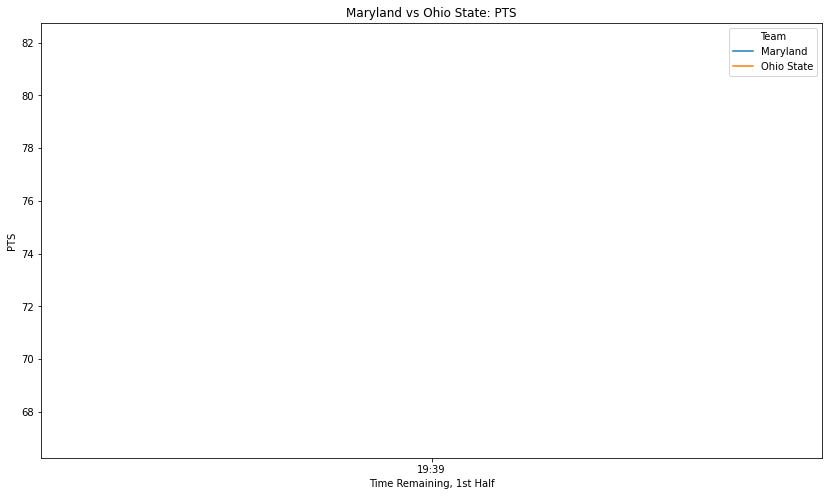

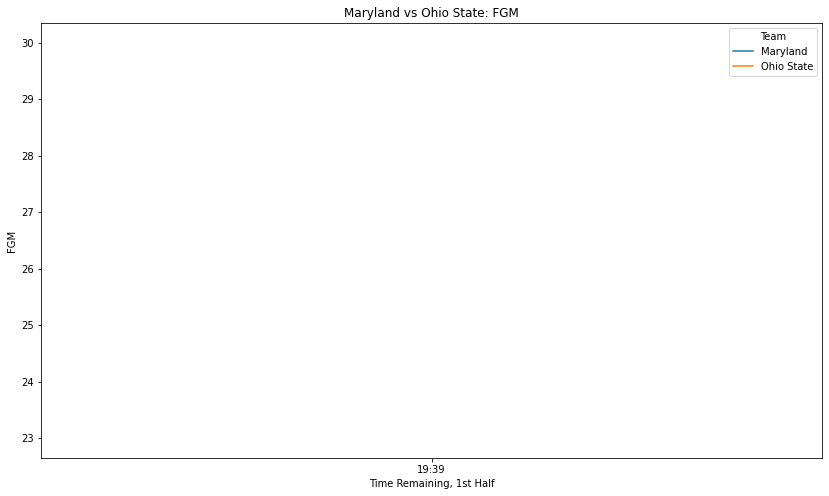

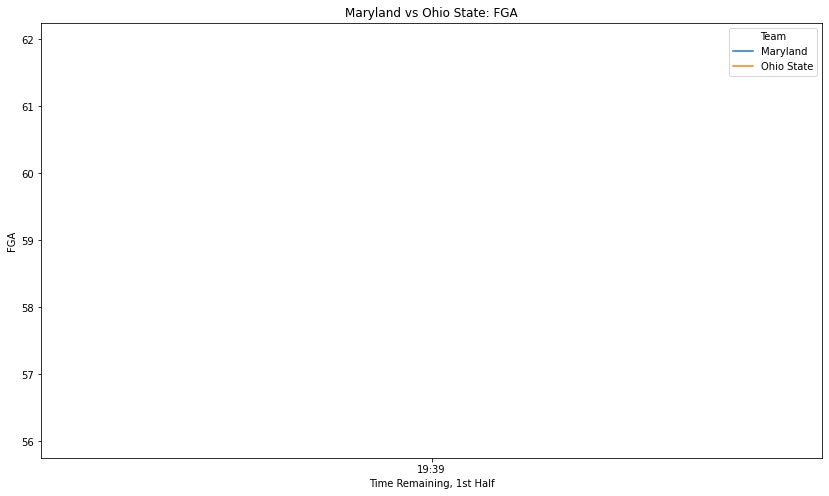

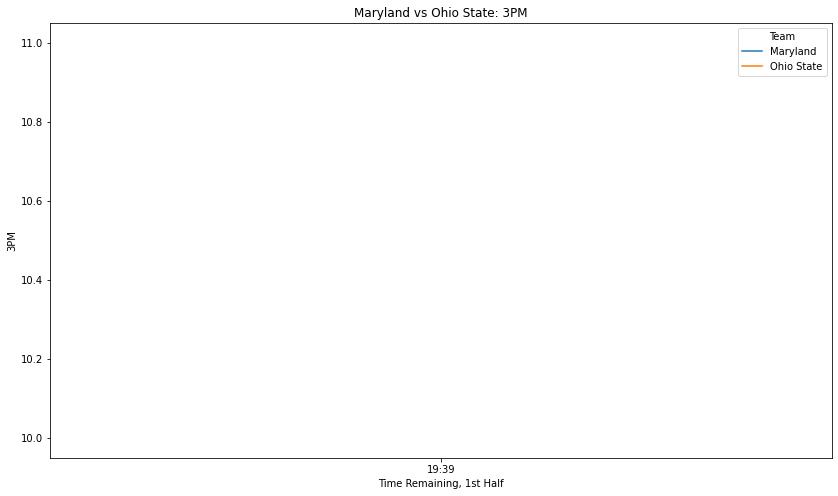

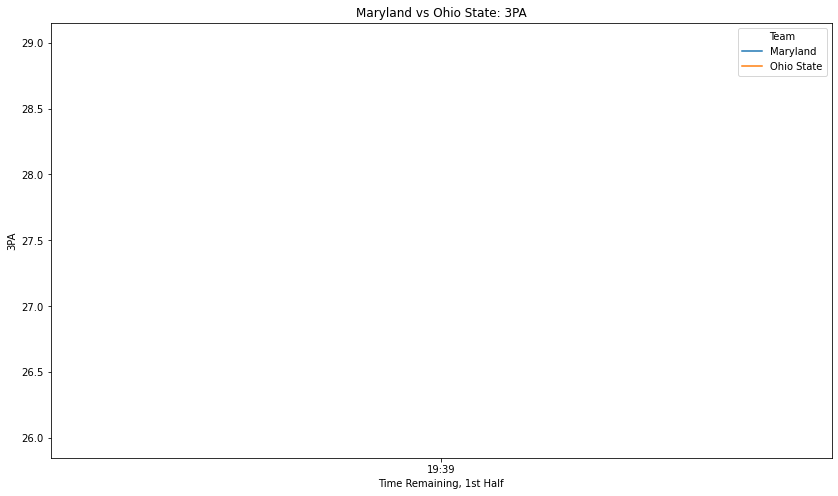

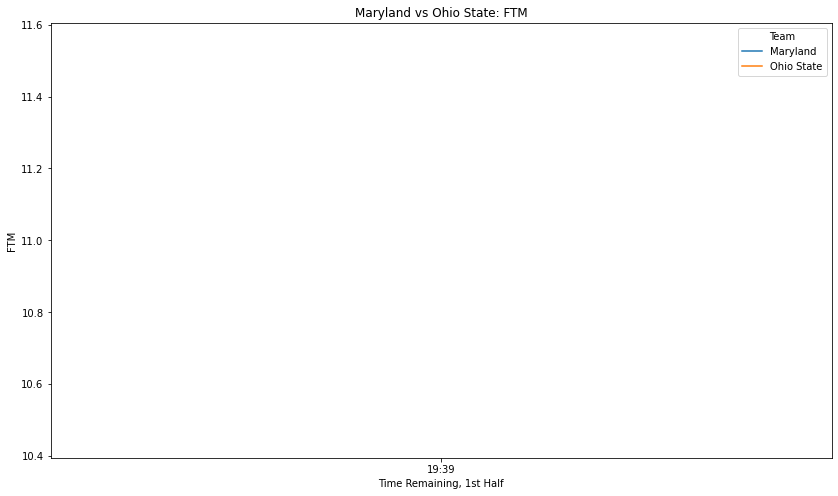

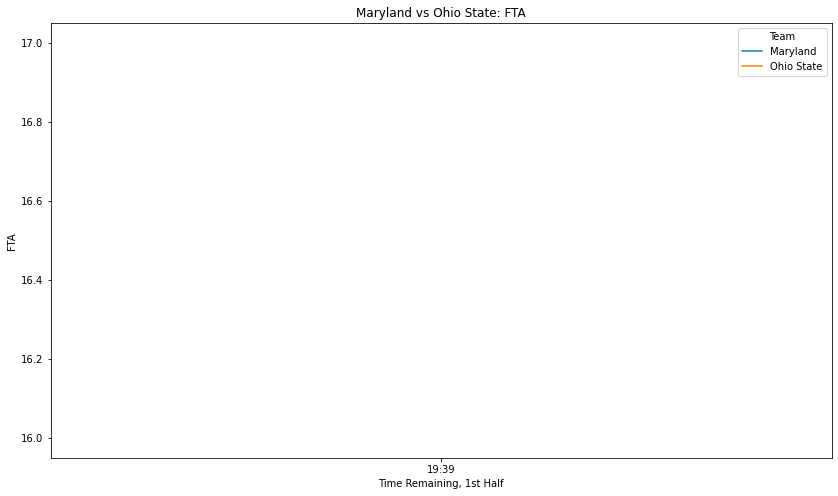

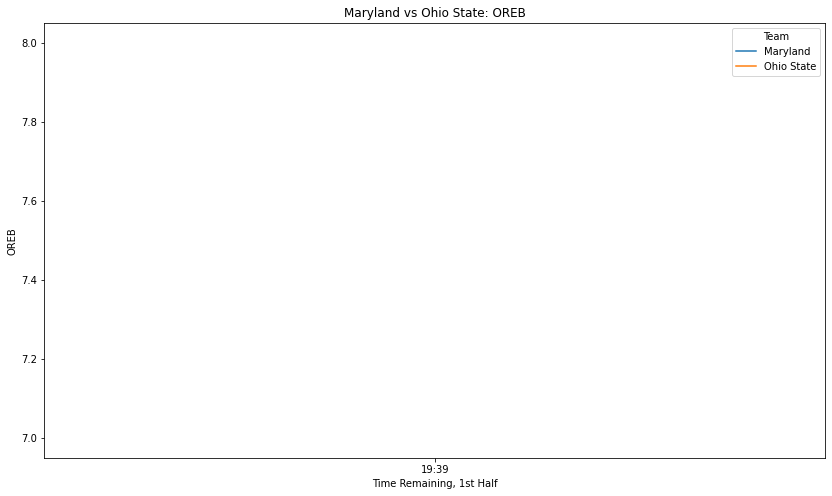

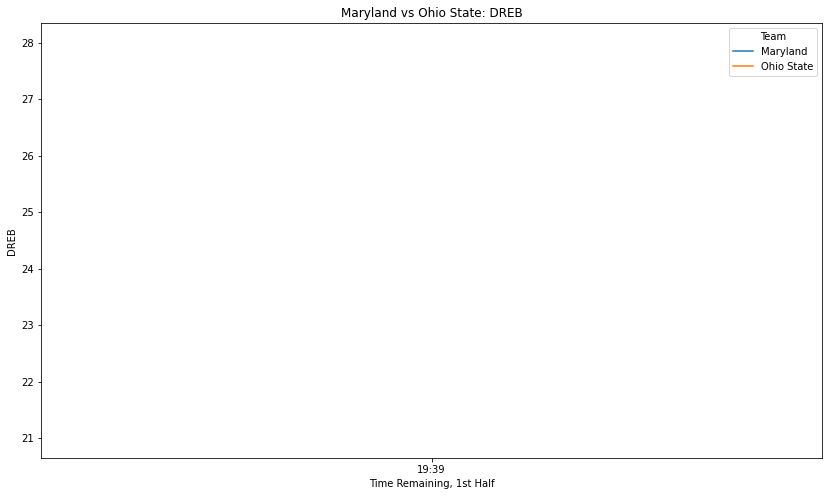

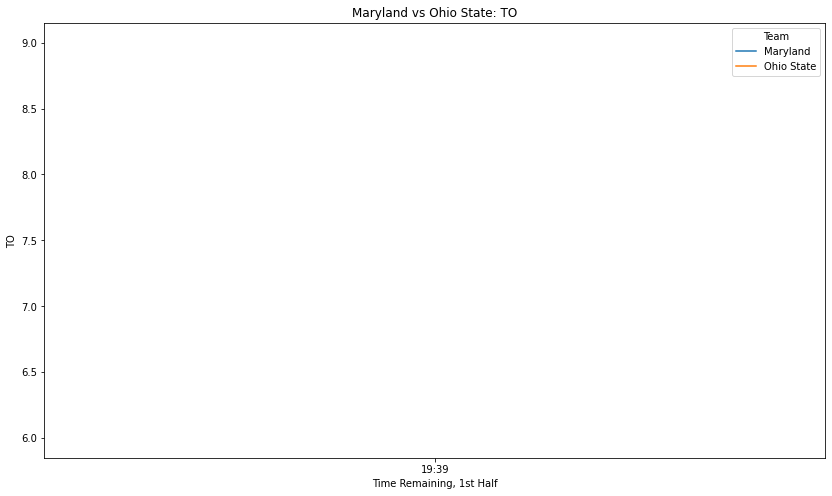

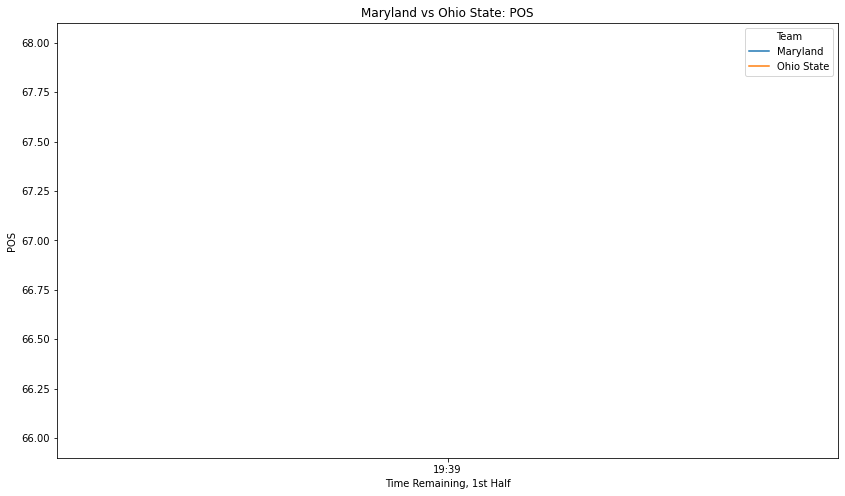

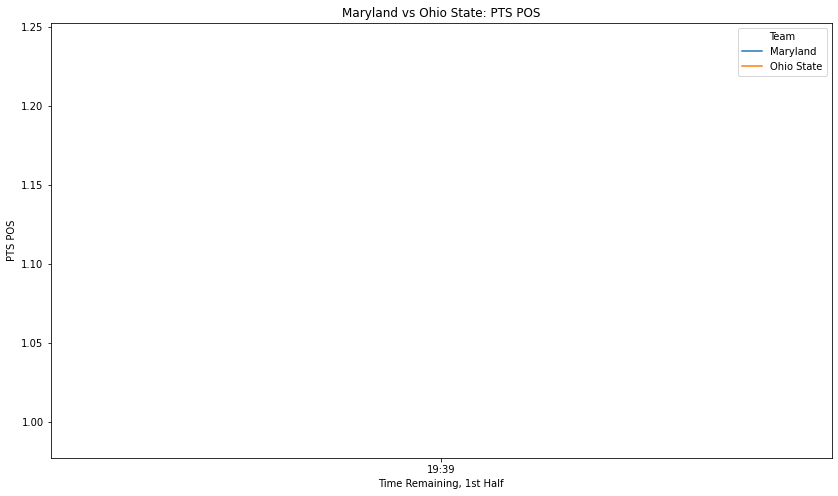

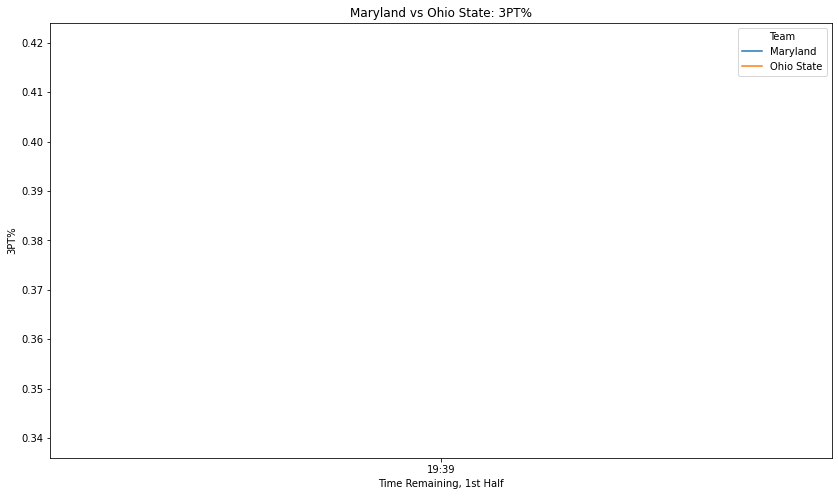

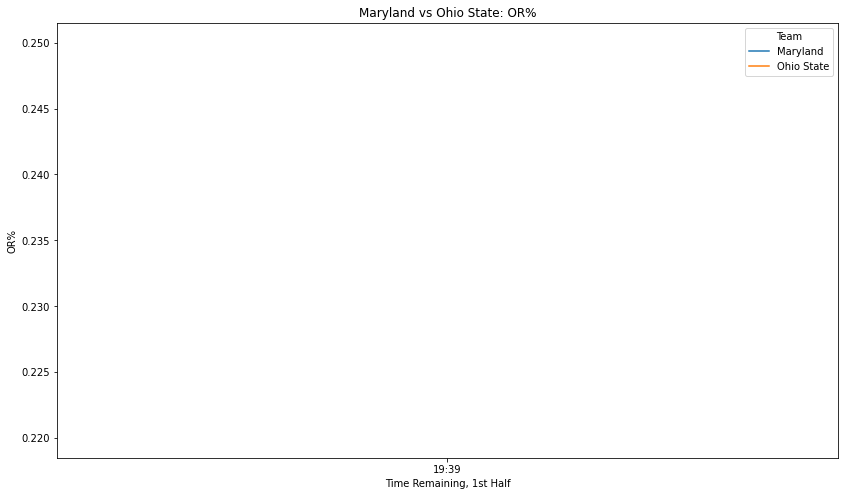

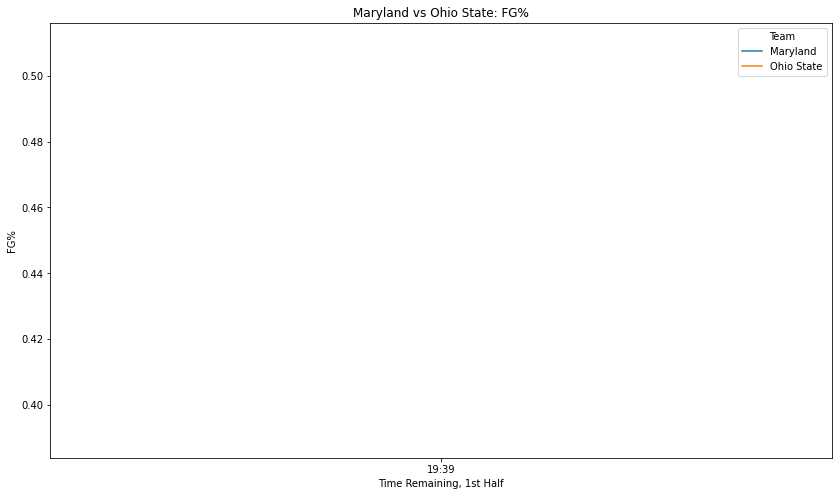

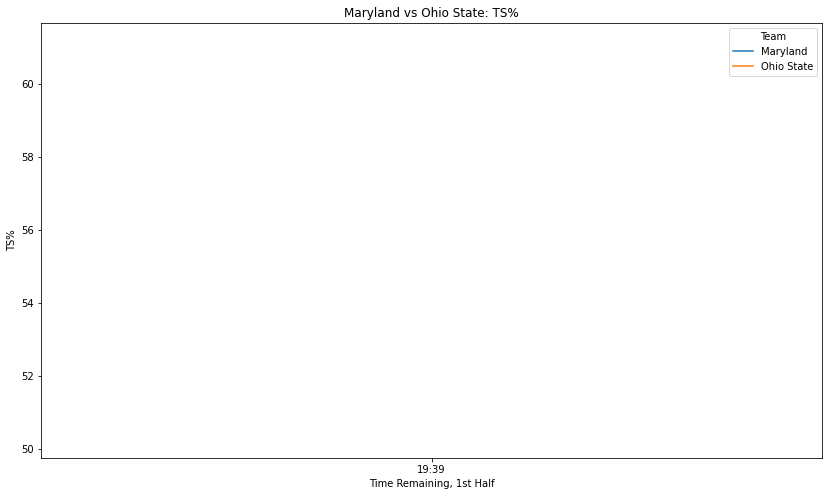

In [215]:
for i in test_df.columns.tolist()[:16]:
  plt.figure(figsize = (14,8))
  sns.lineplot(data = test_df,
              x = 'Timestamp',
              y = i,
              hue = test_df.index)
  plt.title(f"{test_df.index.tolist()[0]} vs {test_df.index.tolist()[1]}: {i.replace('_',' ')}")
  plt.ylabel(i.replace('_',' '))
  plt.xlabel('Time Remaining, 2nd Half')
  if half == 1:
    plt.xlabel('Time Remaining, 1st Half')
  plt.show();